In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [12]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


C:\Users\12243\AppData\Local\Temp\ipykernel_13828\2639776237.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [13]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"Most recent date: {most_recent_date}")

Most recent date: 2017-08-23


Date one year before: 2016-08-23


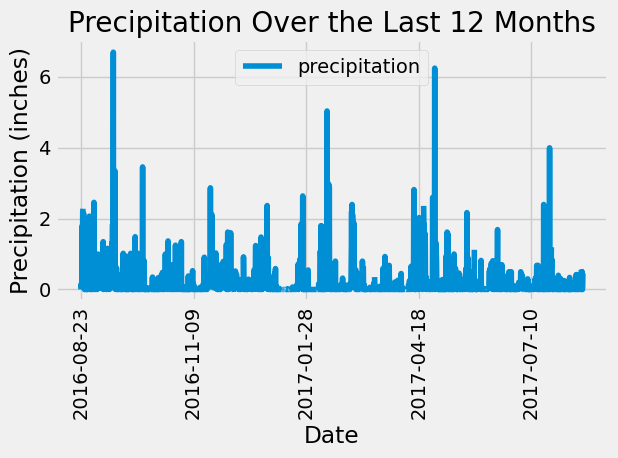

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Measurement.date)).scalar()
# Calculate the date one year from the last date in data set.
year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)
year_ago_str = year_ago.strftime('%Y-%m-%d')  # Convert to string format 'YYYY-MM-DD'
print(f"Date one year before: {year_ago_str}")

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago_str).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
precip_df.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(rot=90)
plt.title("Precipitation Over the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.tight_layout()
plt.show()

In [23]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_summary = precip_df.describe()
print(precip_summary)

       precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [24]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {station_count}")

Total number of stations: 9


In [28]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Get the most active station (the first one in the sorted list)
most_active_station = active_stations[0][0]  # Extract the station ID
print(f"Most active station: {most_active_station}")

# List the stations and their counts in descending order.
print("Most active stations:")
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Most active station: USC00519281
Most active stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [29]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

# Display
print(f"Temperature stats for the most active station {most_active_station}: {temp_stats}")

Temperature stats for the most active station USC00519281: [(54.0, 85.0, 71.66378066378067)]


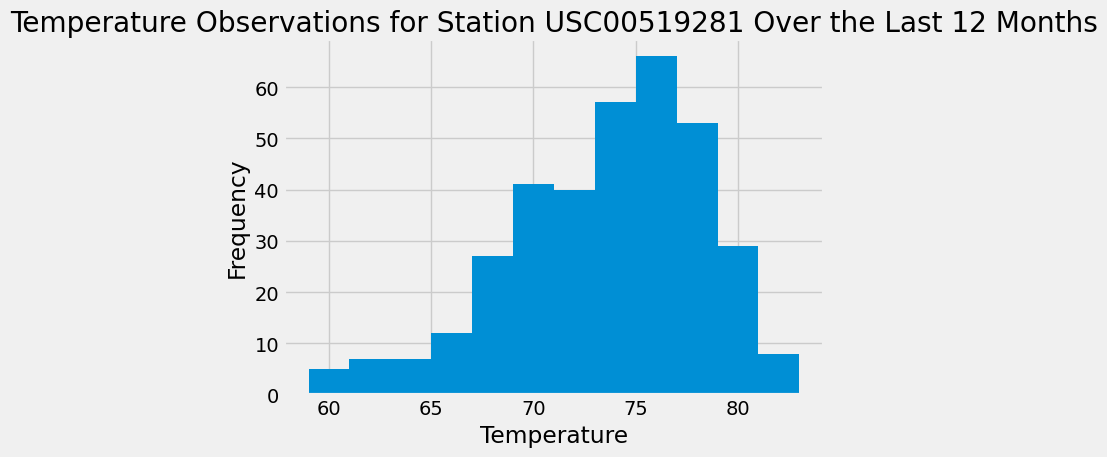

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= year_ago_str).all()

# Convert the query results to a DataFrame
temp_df = pd.DataFrame(temp_data, columns=['date', 'temperature'])

# Plot the results as a histogram
temp_df['temperature'].plot(kind='hist', bins=12)
plt.title(f"Temperature Observations for Station {most_active_station} Over the Last 12 Months")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Close Session

In [32]:
# Close Session
session.close()